# DTSA 5511 Introduction to Deep Learning Final Project

Location of this project: https://github.com/NikoKuu/Introduction-to-Deep-Learning-final

## Project Topic ##
This work is the final project for DTSA 5511 Introduction to Deep Learning course. The objective is to demonstrate how to use Deep Learning methods, including data cleaning and eploratory data analysis (EDA). 

A dataset of Amazon webstore item descriptions by Pavlo Mospan was selected.
Kaggle is hosting the data set:

Amazon Advertisements, Pavlo Mospan 2019. 

Available at: https://www.kaggle.com/datasets/sachsene/amazons-advertisements/data. 

The plan is to clean up the data, perform basic Exploratory Data Analysis (EDA), vectorize the text descriptions of each item and use Natural Language Processing methods to **categorize the data**. Since the descriptions are sequential data, Recurrent Neural Network (RNN) could be a good fit for this data. Multiple RNN family networks are evaluated, such as Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU). Since the structure of the product descriptions is very simple (barely complete sentences), a traditional machine learing models such as Random Forest should also work well. Thus the NLP/RNN approach will be benchmarked against more traditional approaches.  

## Data ##
The data set consists of 525 csv-files (total of 280MB) in different levels of categories, totaling more than three million items with description. There are about 20 main categories and up to three levels of additional nested categories. The main focus of this work is to cluster the items based on the description text mainly focusing on the main category. 

Some of the text descriptions are very short and frankly impossible to categorize, such as a one-word text of the product part number. The text data also has a lot of numerical values for product dimensions or package quantity that may cause trouble for algorithms. 

Each csv-file has only a column named 'ad' and the first row is the header. Rest of the rows are item description text each item in the category. Category name is extracted from the filename. These files have csv file extensions but they should not treated as such since some of the text have commas in them. 

#### Load the most of the required modules

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import string

import keras
import tensorflow as tf
from keras import layers

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score, RocCurveDisplay, roc_auc_score
%matplotlib inline

## Data Cleaning ##

The default categorization is cleaned by making the following changes and corrections:
* Move items in "home kitchen" category to main category "home" and subcategory "kitchen".
    * There already were some items in the home/kitchen -category.
* Move items in main category industrial/scientific category to common main category "industrial scientific".
    * There already were items in the "industrial scientific" -category.
* "Computers" moved under "electronics" main category
* "Smart home" moved under "electronics" main category
* Fix typo in 'sports'
    * No effect on the categories

Also, puncuation are either removed or made consistent. Word counts are also added for each item to aid in the EDA. 

The code below also does additional cleaning however some of it is not necessary since the vectorizer can do it. 


In [33]:
class amz_data:
    def __init__(self):
        self.id = 0
        self.df = pd.DataFrame()
        self.df_cat = pd.DataFrame(columns=['full', 'main', 'sub', 'subsub', 'bottom'])
        self.placeholder = ''#'<NUM>'

    def read_data(self, basedir):
         # https://docs.python.org/3.9/library/os.html?highlight=os%20walk
        for root, dirs, files in os.walk(basedir):
            #print(files)
            for file in files:
                path = os.path.join(root, file)
                self.add_to_dataframe(path)

    def add_to_dataframe(self, path):
        # print(path)
        # Too long path name. Needed to add the prefix for long path names.
        with open(u'\\\\?\\' + os.path.abspath(path), 'r', encoding="utf8") as f:
            # lines = f.readlines()
            lines = f.read().splitlines() # without the \n in the end 
        df = pd.DataFrame(lines[1:], columns=['description'])
        df['id'] = self.id # Assign a unique id
        df['word_count'] = df.apply(self.count_words, axis=1)
        df['description'] = df.apply(self.preprocess_text, axis=1)
        categories = list(self.get_category(os.path.basename(path)))
        df['full'] = categories[0]
        df['main'] = categories[1]
        df['sub'] = categories[2]
        df['subsub'] = categories[3]
        df['bottom'] = categories[4]
        self.df = pd.concat([self.df, df], ignore_index=True)
        # self.df_cat = pd.concat([self.df_cat, [self.id, self.get_category(os.path.basename(path))]], ignore_index=True)
        self.df_cat.loc[len(self.df_cat)] = list(categories)
        self.id = self.id + 1
    
    def get_category(self, file_name):
        if 'home-kitchen' in file_name: # Home kitchen -exception
            file_name = file_name.replace('home-kitchen', 'home_kitchen')
        if 'industrial_scientific' in file_name: # Industrial scientific -exception
            file_name = file_name.replace('industrial_scientific-tests-measurements', 'industrial_scientific_tests-measurements')
            file_name = file_name.replace('industrial_scientific', 'industrial-scientific')
        if '_computers' in file_name: # Computers -exception
            file_name = file_name.replace('_computers', '_electronics_computers')
        if '_smart-home' in file_name: # Smart home -exception
            file_name = file_name.replace('_smart-home', '_electronics_smart-home')
        if 'fan-shop' in file_name: # Fan shop -correction
            file_name = file_name.replace('fan-shop', 'sports-outdoors_fan-shop')
        if 'aports' in file_name: # aports -correction
            file_name = file_name.replace('aports', 'sports')
        category = file_name.split('.')[0]
        cat_list = category.split('_')        
        main = cat_list[1]
        if len(cat_list) >= 4:
            sub = cat_list[2]
        else:
            sub = None
        if len(cat_list) >= 5:
            subsub = cat_list[3]
        else: 
            subsub = None
        bottom = cat_list[-1]
        return category.replace('amazon_',''), main, sub, subsub, bottom
    
    def count_words(self, row):
        words = len(row['description'].split(' '))
        return words
    
    def replace_numbers(self, row):
        text = re.sub(r'\d+', self.placeholder, row['description'])
        return text
    
    def replace_punct_digits(self, text):
        translator = str.maketrans('', '', string.punctuation + string.digits)
        return text.translate(translator)
    
    def replace_multispace(self, text):
        cleaned_text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
        return cleaned_text
    
    def replace_units(self, text):
        text = text.replace('mm','')
        text = text.replace('inches','')
        text = text.replace('inch','')
        text = text.replace('pack','')
        text = text.replace('pcs','')
        text = text.replace('pieces','')
        return text
        
    def preprocess_text(self, row):
        # Remove not helpful words
        text = row['description']
        text = text.lower()
        text = text.replace('|',' ')
        text = text.replace('/',' ')
        text = text.replace(' - ',', ')
        text = text.replace('-',' ')
        text = text.replace('"','')
        text = text.strip()
        pattern = r'\b[a-zA-Z]\b' # Replace single-character words 
        text = re.sub(pattern, '', text)
        # text = self.replace_punct_digits(text)
        text = self.replace_multispace(text)
        return text


#### Loading the data

Load the data from Kaggle, execute the cleaning functions and change category labels' datatype to category (uses less memory).

In [34]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sachsene/amazons-advertisements")

amz = amz_data()
amz.read_data(os.path.join(path, 'scrapped_data', 'scrapped_data'))
print(path)

amz.df['full'] = amz.df['full'].astype('category')
amz.df['main'] = amz.df['main'].astype('category')
amz.df['sub'] = amz.df['sub'].astype('category')
amz.df['subsub'] = amz.df['subsub'].astype('category')
amz.df['bottom'] = amz.df['bottom'].astype('category')

C:\Users\nikok\.cache\kagglehub\datasets\sachsene\amazons-advertisements\versions\1


### Dataset info ###

General info and four first and last entries are printed out below to show the general format of the data. 

The dataframe has over three million rows. However, it was found that there are over 150,000 duplicated entries (identical rows). These duplicates had the same category. There are 765,000 duplicate descriptions with different category. Since the models are trying to categorize each item into one category (one-hot coding), these multicategory entries are also removed. Total of ~800,000 items were removed as duplicates. 

No missing values were found besides the expected items that do not have as many sub-categories. 

In [35]:
print(amz.df.info(),'\n')
print(amz.df.head(4),'\n')
print(amz.df.tail(4),'\n')
print('\nNumber of nan values:\n', np.sum(amz.df.isna(), axis=0))
print('\nNumber of duplicated entries:', np.sum(amz.df.duplicated()))
print('Number of duplicated items:', np.sum(amz.df.duplicated(subset='description')))
print('Drop duplicates...')
amz.df.drop_duplicates(inplace=True, subset='description')
print('Number of duplicated items:', np.sum(amz.df.duplicated(subset='description')))
print('Number of items after dropping duplicates:', len(amz.df))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3318260 entries, 0 to 3318259
Data columns (total 8 columns):
 #   Column       Dtype   
---  ------       -----   
 0   description  object  
 1   id           int64   
 2   word_count   int64   
 3   full         category
 4   main         category
 5   sub          category
 6   subsub       category
 7   bottom       category
dtypes: category(5), int64(2), object(1)
memory usage: 98.1+ MB
None 

                                         description  id  word_count  \
0  hisense 50 inch 4k ultra hd smart led tv 50h60...   0          10   
1  vizio 55 inches 4k ultra hd smart led tv p55 e...   0          11   
2  sony xbr49x900e series 49 class hdr uhd smart ...   0           8   
3  tivo bolt vox 1tb, dvr & streaming media playe...   0          17   

                     full         main  sub subsub      bottom  
0  electronics_smart-home  electronics  NaN    NaN  smart-home  
1  electronics_smart-home  electronics  NaN    NaN  smar

Total of 439 most detailed level categories were found and those are grouped into 17 main categories.

In [36]:
print(amz.df_cat.info(), '\n')
print('Any duplicated categories:', np.any(amz.df_cat.duplicated()), '\n')
print('Number of full categories:', len(pd.unique(amz.df_cat['full'])))
print('Number of main categories:', len(pd.unique(amz.df_cat['main'])))
print('Number of sub-categories:', len(pd.unique(amz.df_cat['sub'])))
print('Number of lower sub-categories:', len(pd.unique(amz.df_cat['subsub'])))
print('Number of most detailed categories:', len(pd.unique(amz.df_cat['bottom'])))

<class 'pandas.core.frame.DataFrame'>
Index: 525 entries, 0 to 524
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   full    525 non-null    object
 1   main    525 non-null    object
 2   sub     390 non-null    object
 3   subsub  48 non-null     object
 4   bottom  525 non-null    object
dtypes: object(5)
memory usage: 24.6+ KB
None 

Any duplicated categories: False 

Number of full categories: 525
Number of main categories: 17
Number of sub-categories: 29
Number of lower sub-categories: 12
Number of most detailed categories: 439


## Exploratory Data Analysis ##

### Word counts

Below a histogram of approximate word counts is plotted. The distribution looks reasonable.

Also the shortest and the longest desriptions are found showing that the shortest has only one word and the longest has 186 words in them. The mean of the number of words is 13 with standard deviation of 7. We can see that using only 25 words covers already majority of the items and 98% of the items have 31 or less words. 

Lastly, the box plot shows how many words each main category has. There does not seem to be significant difference in the description length between the main categories.  

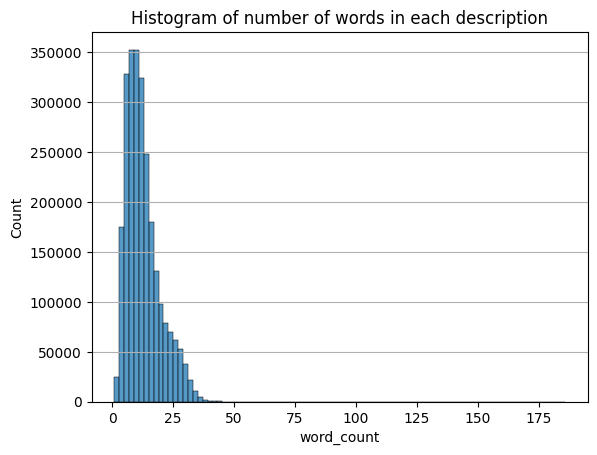

Maximum number of words: 186
Minimum number of words: 1
Mean number of words: 13
Standard deviation of number of words: 7 

Entry with the minimum amount of words:
 description                b06xpp7wjz
id                                  0
word_count                          1
full           electronics_smart-home
main                      electronics
sub                               NaN
subsub                            NaN
bottom                     smart-home
Name: 799, dtype: object
98th percentile: 31.0


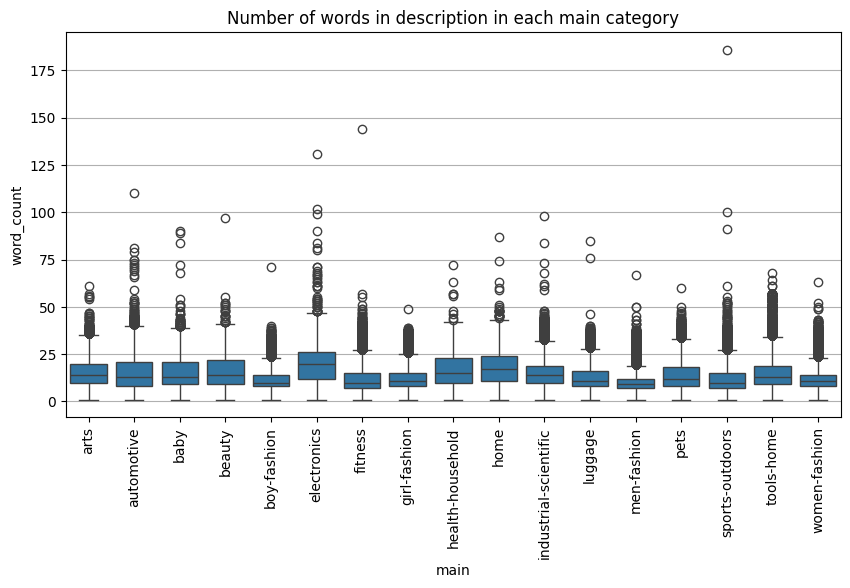

In [37]:
sns.histplot(amz.df, x='word_count', binwidth=2)
plt.grid(axis='y')
plt.title('Histogram of number of words in each description')
plt.show()
print('Maximum number of words:', max(amz.df['word_count']))
print('Minimum number of words:', min(amz.df['word_count']))
print('Mean number of words:', round(np.mean(amz.df['word_count'])))
print('Standard deviation of number of words:', round(np.std(amz.df['word_count'])), '\n')
print('Entry with the minimum amount of words:\n', amz.df.iloc[np.argmin(amz.df['word_count'])])
print('98th percentile:', np.percentile(amz.df['word_count'],98))

fig = plt.figure(figsize=(10, 5))
sns.boxplot(amz.df, x='main', y='word_count')
plt.xticks(rotation=90, fontsize = 10) 
plt.title('Number of words in description in each main category')
plt.grid(axis='y')
plt.show()


#### Number of items in each category

Below, first the number of items in each main category is plotted. Then then number of items in each detailed category is plotted. 

Women's fashion is the largest main category with over 500,000 items and health household has the least amount of items. 

In detailed categories, fan shop is extremely large category (73,000 items) compared to the others and some categories have only 6 items. Learning from very small categories may not work well.

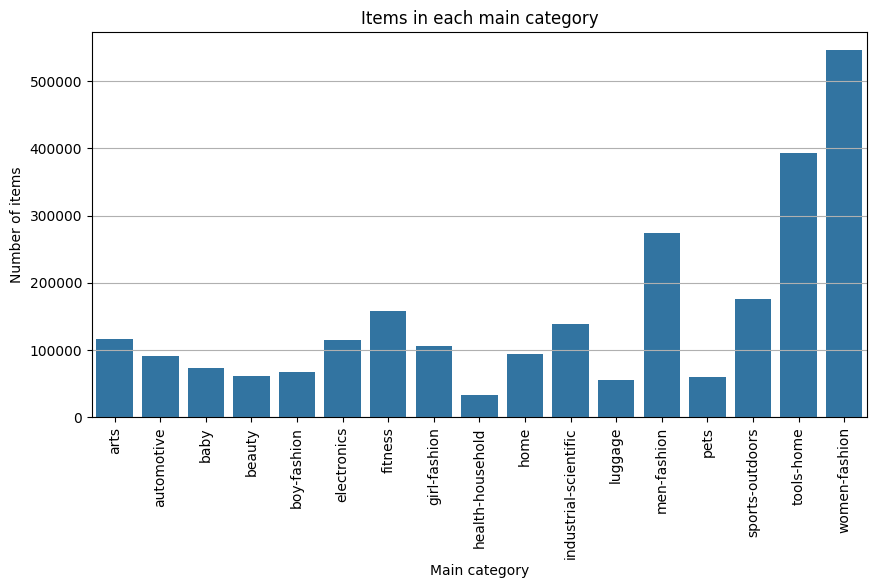

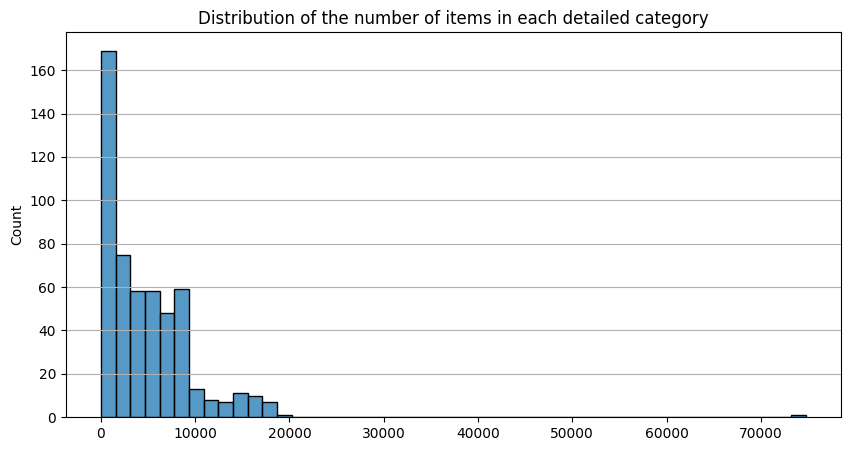

Maximum number of items: 74742
Minimum number of items: 6
Mean number of items: 4864
Standard deviation of number of items: 5259 

Item count of the five largest categories:
 full
sports-outdoors_fan-shop         74742
women-fashion_jewelry_body       18876
girl-fashion_jewelry_earrings    18448
men-fashion_access_sunglasses    18337
men-fashion_watches              18282
dtype: int64 

Item count of the five smallest categories:
 full
sports-outdoors_recreation_water-sports_clothing     6
fitness_running_gps                                  7
tools-home_appliances_dishwasher                    15
boy-fashion_jewelry_tie-clips                       30
tools-home_appliances_ranges                        30
dtype: int64


In [38]:
fig = plt.figure(figsize=(10, 5))
sns.countplot(amz.df, x='main', stat='count')
plt.title('Items in each main category')
plt.xlabel('Main category')
plt.ylabel('Number of items')
plt.xticks(rotation=90, fontsize = 10)
plt.grid(axis='y')
plt.show()

fig = plt.figure(figsize=(10, 5))
sizes = amz.df.groupby('full', observed=True).size()
sns.histplot(sizes)
plt.title('Distribution of the number of items in each detailed category')
plt.grid(axis='y')
plt.show()

print('Maximum number of items:', max(sizes))
print('Minimum number of items:', min(sizes))
print('Mean number of items:', round(np.mean(sizes)))
print('Standard deviation of number of items:', round(np.std(sizes)), '\n')

print('Item count of the five largest categories:\n', sizes.sort_values(ascending=False)[0:5], '\n')
print('Item count of the five smallest categories:\n', sizes.sort_values(ascending=True)[0:5])


### Dataset preparation

The code below allows to select a random subset of certain number of categories, either using main or most detailed category. The models in this work will be trained with full dataset and main-category. 

In [39]:
import random
random.seed(215)
number_of_categories = 17

main_category = True
truncate = False

mask = []
counts_train = []
if main_category:
    cat_name = 'main'
else:
    cat_name = 'full'
chosen_categories = random.sample(list(pd.unique(amz.df_cat[cat_name])), number_of_categories)
for index, cat in enumerate(chosen_categories): # Find the rows with target categories
    m = amz.df[cat_name] == cat
    counts_train.append(sum(m)) # Record the number of items 
    mask.append(m)
amount = min(counts_train)
idx_all = []
for index, cat in enumerate(chosen_categories):
    m = amz.df[cat_name] == cat
    if truncate:
        idx_all.append(np.where(m)[0][0:amount])
    else:
        idx_all.append(np.where(m)[0])

idx_all = [item for sublist in idx_all for item in sublist]
df = amz.df.iloc[idx_all]

chosen_categories = pd.unique(df[cat_name])
# categories_train = [s.replace('-',' ').replace('_',' - ') for s in categories_train]
print('Chosen categories and number of items:')
print('\n'.join([cat+': '+str(cnt) for cat, cnt in zip(chosen_categories, counts_train)]))
temp_df = pd.DataFrame(np.array([chosen_categories, counts_train]).transpose(), columns=['category', 'items'])


Chosen categories and number of items:
arts: 116128
luggage: 55010
women-fashion: 545838
sports-outdoors: 175390
beauty: 60892
baby: 72474
fitness: 157428
electronics: 114517
home: 93186
girl-fashion: 106459
automotive: 90845
boy-fashion: 67428
industrial-scientific: 139219
pets: 59668
health-household: 32418
men-fashion: 273552
tools-home: 393049


The data is split into following sub-datasets:

* 70% training
* 20% validation
* 20% test

The splitting function also tries to stratify the data so the uneven categories do not skew the model training. 

In [40]:
test_split = 0.4

# Initial train and test split.
train_df, test_df = train_test_split(
    df,
    test_size=test_split,
    stratify=df[cat_name].values,
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: \t{len(train_df)}, \t{round(100*len(train_df)/len(df))}%")
print(f"Number of rows in validation set: \t{len(val_df)}, \t{round(100*len(val_df)/len(df))}%")
print(f"Number of rows in test set: \t\t{len(test_df)}, \t{round(100*len(test_df)/len(df))}%")

Number of rows in training set: 	1532100, 	60%
Number of rows in validation set: 	510700, 	20%
Number of rows in test set: 		510701, 	20%


We use standard batch size of 32, maximum of 20,000 word vocabulary and the descriptions truncated at 31 words. 

In [41]:
# Model constants.
batch_size = 32
max_features = 20000
embedding_dim = 128
sequence_length = 31

Since this is multi-category classification we need to have the categories one-hot binary coded. 

In [42]:
# https://keras.io/examples/nlp/multi_label_classification/
terms = tf.ragged.constant(train_df[cat_name].values)
lookup = layers.StringLookup(output_mode="one_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()

def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe[cat_name].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["description"].values, label_binarized)
    )
    if is_train:
        dataset = dataset.shuffle(batch_size * 10)  
    return dataset.batch(batch_size)
def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)

In [43]:
train_ds = make_dataset(train_df, is_train=True)
val_ds = make_dataset(val_df, is_train=False)
test_ds = make_dataset(test_df, is_train=False)

A couple of samples pulled from the training dataset with one-hot coding.

In [44]:
for text_batch, label_batch in train_ds.take(6):
    for i in range(1):
        print('*' * 80)
        print(label_batch.numpy()[i], '\t\t', invert_multi_hot(label_batch.numpy()[i]))
        print(text_batch.numpy()[i])


********************************************************************************
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 		 ['women-fashion']
b'bimba boho long flaired maxi tier skirt elastic waist rayon bohemian skirts'
********************************************************************************
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 		 ['tools-home']
b'prime line products pl 14891 20ea slide bolt spring,(pack of 20)'
********************************************************************************
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 		 ['women-fashion']
b'pattyboutik women boatneck sweetheart inset floral lace blouse'
********************************************************************************
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] 		 ['fitness']
b'jp korsteel slow twist full cheek eggbutt snaffle bit, 4.75'
********************************************************************************
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 		 ['women-fashion']
b"jotebriyo women' linen&cotton t

The words in the training set need to be vectorized. The below code makes the vectorizer that can be used to transform text data to number matrices. 

In [45]:
# https://keras.io/examples/nlp/text_classification_from_scratch/

vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_features,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=sequence_length,
    pad_to_max_tokens=False,
    vocabulary=None,
    idf_weights=None,
    sparse=False,
    ragged=False,
    encoding='utf-8',
    name=None
)
# Now that the vectorize_layer has been created, call `adapt` on a text-only
# dataset to create the vocabulary. You don't have to batch, but for very large
# datasets this means you're not keeping spare copies of the dataset in memory.

# Let's make a text-only dataset (no labels):
text_ds = train_ds.map(lambda x, y: x)
# Let's call `adapt`:
vectorize_layer.adapt(text_ds)

In [46]:
# https://keras.io/examples/nlp/text_classification_from_scratch/
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label


# Vectorize the data.
train_ds = train_ds.map(vectorize_text)
val_ds = val_ds.map(vectorize_text)
test_ds = test_ds.map(vectorize_text)

# Do async prefetching / buffering of the data for best performance on GPU.
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)

An example of a sample from the dataset with text vectorized.

In [47]:
for text_batch, label_batch in train_ds.take(2):
    for i in range(1):
        print('*' * 80)
        print(label_batch.numpy()[i], '\n', text_batch.numpy()[i])
print('\nVectorized text datatype:', type(text_batch.numpy()[i][0]))

********************************************************************************
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 
 [  1   8 168  81 692   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0]
********************************************************************************
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 
 [4404  245  135    1 4284    2    9   12    9   18 1805 4404  144  269
   96    4 4591  288 3907    0    0    0    0    0    0    0    0    0
    0    0    0]

Vectorized text datatype: <class 'numpy.int64'>


## Models

The input layer is the same in all the models so it can be reused.

The output layer is fully connected neural net with softmax activation. Softmax gives probability for each category and thus makes prediction easier.

In [48]:
# A integer input for vocab indices.
inputs = keras.Input(shape=(None,), dtype="int64")

### 1. Baseline

This is a fairly simple model that uses two convolutional layers (1D convolution layer, good for temporal convolution), and one fully connected layer. Activations are all ReLU, except for the output layer. 

With this model, we can experiment with the number of filters and dropout rates.

Source: https://keras.io/examples/nlp/text_classification_from_scratch/

In [57]:
# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=5)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=5)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(number_of_categories+1, activation="softmax", name="predictions")(x)

model1 = keras.Model(inputs, predictions)

model1.name = 'baseline_5strides'
model1.summary()


Model: "baseline_5strides"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_7 (Embedding)         │ (None, None, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, None, 128)      │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, None, 128)      │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_6          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 18)             │         2,322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,808,466 (10.71 MB)

 Trainable params: 2,808,466 (10.71 MB)

 Non-trainable params: 0 (0.00 B)

### 2. LSTM - Long Short Term Memory network

LSTM network should be able take better account previous words. Overall architecture is similar to the previous model. 

In [26]:
# Embed each integer in a 128-dimensional vector
x = layers.Embedding(max_features, 128)(inputs)
x = layers.Dropout(0.5)(x)
# Add 2 LSTMs
# x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128)(x)
x = layers.Dropout(0.5)(x)
# Add a classifier
outputs = layers.Dense(number_of_categories+1, activation="softmax")(x)
model2 = keras.Model(inputs, outputs)
model2.name = 'LSTM'
model2.summary()


Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, None, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 128)      │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 18)             │         2,322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,825,490 (10.78 MB)

 Trainable params: 2,825,490 (10.78 MB)

 Non-trainable params: 0 (0.00 B)

### 3. LSTM - Long Short Term Memory network

This LSTM adds dropout function into LSTM layers.

In [27]:
## Source: https://www.kaggle.com/code/anmolstha/disaster-tweets-simple-rnn-impleme
# We need sequential model to process sequence of text data
model3 = keras.models.Sequential()
model3.add(inputs)
# Embedding(input_dimension, output_dimension,embeddings_initializer = initialize t
embedding= layers.Embedding(max_features, 128)#, trainable=False)
# Adding Embedding Layer
model3.add(embedding)
# Drops 40% of entire row
model3.add(layers.Dropout(0.5))
# Recurrent Layer LSTM(dimensionality of the output space, dropout = 20%, recurrent
model3.add(layers.LSTM(128, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
model3.add(layers.LSTM(128, dropout=0.5, recurrent_dropout=0.5))
# Decide what we are going to output Dense(units, activation function)
model3.add(layers.Dense(number_of_categories+1, activation='softmax'))
model3.name = 'LSTM-dropout'
model3.summary()


Model: "LSTM-dropout"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, None, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, None, 128)      │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 18)             │         2,322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,825,490 (10.78 MB)

 Trainable params: 2,825,490 (10.78 MB)

 Non-trainable params: 0 (0.00 B)

 ### 4. GRU - Gated Recurrent Unit

The GRU architecture should be slightly lighter than... 

In [28]:
# Embed each integer in a 128-dimensional vector
x = layers.Embedding(max_features, 128)(inputs)
x = layers.Dropout(0.5)(x)
# Add 2 GRUs
x = layers.GRU(128, return_sequences=True)(x)
x = layers.GRU(128)(x)

# Add a classifier
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(number_of_categories+1, activation='softmax')(x)

model4 = keras.Model(inputs, outputs)

model4.name = 'GRU'
model4.summary()


Model: "GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, None, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, None, 128)      │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 18)             │         2,322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,760,466 (10.53 MB)

 Trainable params: 2,760,466 (10.53 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = layers.GRU(32, return_sequences=True)(x)
x = layers.GRU(32, return_sequences=True)(x)
x = layers.GRU(32)(x)

# We add a vanilla hidden layer:
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(number_of_categories+1, activation="softmax", name="predictions")(x)

model4 = keras.Model(inputs, predictions)

model4.name = 'GRU'
model4.summary()


Model: "GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, None, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, None, 32)       │        15,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, None, 32)       │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 32)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 18)             │         2,322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,594,770 (9.90 MB)

 Trainable params: 2,594,770 (9.90 MB)

 Non-trainable params: 0 (0.00 B)

## Train the models

In [50]:
# Source: Microsoft Copilot
import time
from tensorflow.keras.callbacks import Callback

class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.train_start_time = time.time()  # Start timing training
    
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()  # Start timing epoch

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time  # Calculate epoch time
        print(f"\nEpoch {epoch + 1} took {epoch_time:.2f} seconds.")
    
    def on_train_end(self, logs=None):
        total_time = time.time() - self.train_start_time  # Calculate total training time
        print(f"\nTotal training time: {total_time:.2f} seconds.")

In [59]:
def train_save_model(model, epochs=5):
    # Compile the model with binary crossentropy loss and an adam optimizer.
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    # Fit the model using the train and validation datasets.
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)#, callbacks=[TimeHistory()])
    # Save the training history
    result_df = pd.DataFrame(np.array([history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss']]).transpose(), 
                             columns=['acc','val_acc','loss','val_loss'])
    result_df.to_csv(model.name + '.csv')
    # Save the model, including the weights
    model.save(model.name + '.keras')


In [60]:
train_save_model(model1, 5)
model1.evaluate(test_ds)

Epoch 1/5


AbortedError: Graph execution error:

Detected at node StatefulPartitionedCall/gradient_tape/baseline_5strides_1/conv1d_13_1/convolution/Conv2DBackpropInput defined at (most recent call last):
<stack traces unavailable>
Operation received an exception:Status: 2, message: could not create a primitive descriptor for a convolution forward propagation primitive, in file tensorflow/core/kernels/mkl/mkl_conv_grad_input_ops.cc:546
	 [[{{node StatefulPartitionedCall/gradient_tape/baseline_5strides_1/conv1d_13_1/convolution/Conv2DBackpropInput}}]] [Op:__inference_multi_step_on_iterator_11630526]

In [24]:
train_save_model(model2, 5)
model2.evaluate(test_ds)

Epoch 1/5
47879/47879 ━━━━━━━━━━━━━━━━━━━━ 1084s 23ms/step - accuracy: 0.7273 - loss: 0.9074 - val_accuracy: 0.8367 - val_loss: 0.5059
Epoch 2/5
47879/47879 ━━━━━━━━━━━━━━━━━━━━ 1103s 23ms/step - accuracy: 0.8292 - loss: 0.5430 - val_accuracy: 0.8435 - val_loss: 0.4816
Epoch 3/5
47879/47879 ━━━━━━━━━━━━━━━━━━━━ 1130s 24ms/step - accuracy: 0.8372 - loss: 0.5132 - val_accuracy: 0.8466 - val_loss: 0.4731
Epoch 4/5
47879/47879 ━━━━━━━━━━━━━━━━━━━━ 1134s 24ms/step - accuracy: 0.8411 - loss: 0.5001 - val_accuracy: 0.8475 - val_loss: 0.4690
Epoch 5/5
47879/47879 ━━━━━━━━━━━━━━━━━━━━ 1142s 24ms/step - accuracy: 0.8428 - loss: 0.4928 - val_accuracy: 0.8486 - val_loss: 0.4648
15960/15960 ━━━━━━━━━━━━━━━━━━━━ 168s 11ms/step - accuracy: 0.8477 - loss: 0.4680


[0.46797120571136475, 0.848055899143219]

In [ ]:
train_save_model(model3, 5)
model3.evaluate(test_ds)

In [141]:
train_save_model(model4, 5)
model4.evaluate(test_ds)

## Alternative methods


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

my_vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.95, min_df=5, 
                                    norm='l2', encoding='latin-1', ngram_range=(1, 2), 
                                    stop_words="english", max_features=1000, strip_accents='ascii')
X_train = my_vectorizer.fit_transform(train_df['description'])

print('Shape of the matrix:', X_train.shape)
ftr_names = my_vectorizer.get_feature_names_out()
print('Length of ftr_names:',len(ftr_names))
print('Sample of the feature names:\n', ftr_names[100:200])

In [ ]:
from sklearn.ensemble import RandomForestClassifier

my_RF = RandomForestClassifier().fit(X_train, train_df['main']) # Create the model
y_hat_RF = my_RF.predict(test_df['description'])
accuracy = accuracy_score(test_df['main'], y_hat_RF)


## Sources


https://keras.io/examples/nlp/text_classification_from_scratch/

https://keras.io/examples/nlp/bidirectional_lstm_imdb/

https://keras.io/examples/nlp/multi_label_classification/

https://keras.io/examples/nlp/multi_label_classification/

https://www.kaggle.com/code/anmolstha/disaster-tweets-simple-rnn-impleme

My final project for DTSA 5510 Unsupervised Algorithms in Machine Learning
